<a href="https://colab.research.google.com/github/Whoami666/HSE_Lab/blob/main/clean_models/schiz_models_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [6]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 6.7 MB/s eta 0:00:00


In [8]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [21]:
def calculate_scores(model, givenx, giveny, xtest):
  kf = KFold(n_splits=10)
  crossval_f1 = cross_val_score(model, givenx, giveny, scoring='f1_macro', cv = kf)
  mean_score = crossval_f1.mean()
  std_score = crossval_f1.std()
  print('f1_macro', mean_score, '±', std_score)

  crossval_accuracy = cross_val_score(model, givenx, giveny, scoring='accuracy', cv = kf)
  mean_score = crossval_accuracy.mean()
  std_score = crossval_accuracy.std()
  print('accuracy', mean_score, '±', std_score)

  crossval_recall = cross_val_score(model, givenx, giveny, scoring='recall_macro', cv = kf)
  mean_score = crossval_recall.mean()
  std_score = crossval_recall.std()
  print('recall', mean_score, '±', std_score)

  if giveny.nunique() == 2:
    y_proba = model.predict_proba(xtest)
    print('roc_auc_score', roc_auc_score(y_test, y_proba[:,1]))

In [22]:
def random_forest_class(xtrain, ytrain, xtest, ytest, xgiven, ygiven):
  warnings.filterwarnings('ignore')

  opt = BayesSearchCV(
      RandomForestClassifier(),
      {
          'n_estimators':  (100, 1000),
          'max_depth': (10, 100),
          'min_samples_split': np.linspace(0.0001, 1, 10),
          'min_samples_leaf': np.linspace(0.0001, 0.5, 10),
      },
      scoring='f1_macro',
      n_iter=32,
      cv=3
  )

  opt.fit(xtrain, ytrain)

  print("val. score: %s" % opt.best_score_)
  print("test score: %s" % opt.score(xtest, ytest))
  print("best_params: %s" % opt.best_params_, '\n')

  rfc = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
  rfc.fit(xtrain, ytrain)
  y_pred = rfc.predict(xtest)
  print(classification_report(ytest,y_pred), '\n')

  calculate_scores(rfc, xgiven, ygiven, xtest)

  sorted_idx = rfc.feature_importances_.argsort()
  feature_names = [f"feature {i}" for i in range(X.shape[1])]
  plt.barh(X.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
  plt.xlabel("Random Forest Feature Importance")

In [11]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


**Non-binary**

All features

In [15]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.45621693121693124
test score: 0.4505376344086021
best_params: OrderedDict([('max_depth', 99), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 119)]) 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        60
           1       0.50      0.33      0.40         6
           2       0.00      0.00      0.00         2

    accuracy                           0.90        68
   macro avg       0.47      0.44      0.45        68
weighted avg       0.86      0.90      0.87        68
 

f1_macro 0.6662901356560778 ± 0.2977241998298552
accuracy 0.8647058823529411 ± 0.19160585264590976
recall 0.6453431372549019 ± 0.2814238644109902


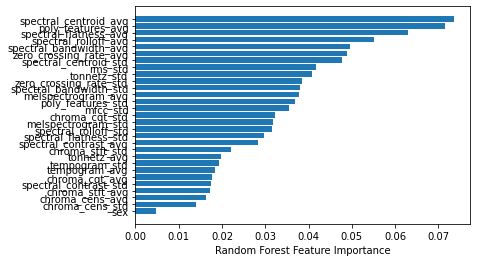

In [16]:
random_forest_class(X_train, y_train, X_test, y_test, X, y)

Only 1D features

In [17]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.48806963645673324
test score: 0.3887407407407408
best_params: OrderedDict([('max_depth', 10), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 1000)]) 

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        60
           1       0.50      0.17      0.25         6
           2       0.00      0.00      0.00         2

    accuracy                           0.90        68
   macro avg       0.47      0.39      0.40        68
weighted avg       0.85      0.90      0.86        68
 

f1_macro 0.5858021123142091 ± 0.28827166863098447
accuracy 0.8643382352941176 ± 0.1896463797471786
recall 0.6015931372549019 ± 0.2661996026853145


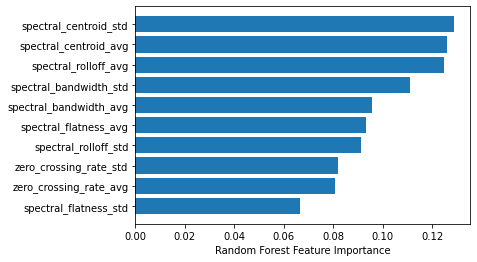

In [18]:
random_forest_class(X_train, y_train, X_test, y_test, X, y)

**Binary**

All features

In [23]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

val. score: 0.6750836817597531
test score: 0.48484848484848486
best_params: OrderedDict([('max_depth', 100), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 1000)]) 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.00      0.00      0.00         2

    accuracy                           0.94        34
   macro avg       0.47      0.50      0.48        34
weighted avg       0.89      0.94      0.91        34
 

f1_macro 0.6811091754201852 ± 0.2618207543220454
accuracy 0.8702205882352942 ± 0.16580882352941176
recall 0.6939443277310924 ± 0.2464676378840118
0.65625


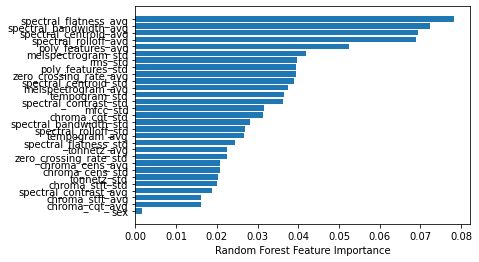

In [24]:
random_forest_class(X_train, y_train, X_test, y_test, X, y)

Only 1D features

In [25]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.5955965181771634
test score: 0.7258064516129032
best_params: OrderedDict([('max_depth', 94), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.2223), ('n_estimators', 413)]) 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        60
           1       0.75      0.38      0.50         8

    accuracy                           0.91        68
   macro avg       0.84      0.68      0.73        68
weighted avg       0.90      0.91      0.90        68
 

f1_macro 0.6827190239050337 ± 0.2605565192227488
accuracy 0.8878676470588236 ± 0.1732959702239142
recall 0.7001943277310925 ± 0.24741183768665093
0.8479166666666667


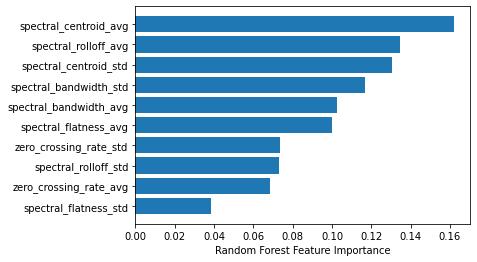

In [26]:
random_forest_class(X_train, y_train, X_test, y_test, X, y)